In [1]:
import os
import time
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import xgboost

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader

import warnings
warnings.filterwarnings(action='ignore')
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Selected device: {device}")

Selected device: cuda


In [2]:
CFG = {
    'EPOCHS':30,
    'LEARNING_RATE':1e-3,
    'BATCH_SIZE':16,
    'SEED':41
}

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED'])

In [3]:
# df_train1 = pd.read_csv(r"../dataset/prep_data/lettuce/labels/training/12_58.csv")
# df_train2 = pd.read_csv(r"../dataset/prep_data/lettuce/labels/training/13_58.csv")
# df_train3 = pd.read_csv(r"../dataset/prep_data/lettuce/labels/training/14_54.csv")
# df_train4 = pd.read_csv(r"../dataset/prep_data/lettuce/labels/training/15_56.csv")
# df_train5 = pd.read_csv(r"../dataset/prep_data/lettuce/labels/training/16_58.csv")
# df_train6 = pd.read_csv(r"../dataset/prep_data/lettuce/labels/training/17_56.csv")

# df_test1 = pd.read_csv(r"../dataset/prep_data/lettuce/labels/validation/18_58.csv")
# df_test2 = pd.read_csv(r"../dataset/prep_data/lettuce/labels/validation/19_58.csv")
# df_test3 = pd.read_csv(r"../dataset/prep_data/lettuce/labels/validation/20_56.csv")

# df_train = pd.concat([df_train1, df_train2, df_train3, df_train4, df_train5, df_train6], ignore_index=True)
# # df_test = pd.concat([df_test1, df_test2, df_test3], ignore_index=True)
# df_test = pd.concat([df_test1], ignore_index=True)

df_train1 = pd.read_csv(r"../dataset/prep_data/lettuce/labels/training/13_58.csv")
df_train2 = pd.read_csv(r"../dataset/prep_data/lettuce/labels/training/14_54.csv")
df_test = pd.read_csv(r"../dataset/prep_data/lettuce/labels/training/17_56.csv")

df_train = pd.concat([df_train1, df_train2], ignore_index=True)
df_test = pd.concat([df_test], ignore_index=True)

X_train_A = df_train[['gardenTemp', 'gardenHumid', 'gardenLight', 'gardenCO2', 'vegetableGrowth']]
y_train_A = df_train['vegetableGrowth']

X_test_A = df_test[['gardenTemp', 'gardenHumid', 'gardenLight', 'gardenCO2', 'vegetableGrowth']]
y_test_A = df_test['vegetableGrowth']

print(X_train_A.shape,len(y_train_A))
print(X_test_A.shape,len(y_test_A))

(16128, 5) 16128
(8064, 5) 8064


In [4]:
p_scaler = StandardScaler()
p_scaler.fit(X_train_A)
train_scaled = p_scaler.transform(X_train_A)
test_scaled = p_scaler.transform(X_test_A)

Mean Squared Error: 30667.566598629375


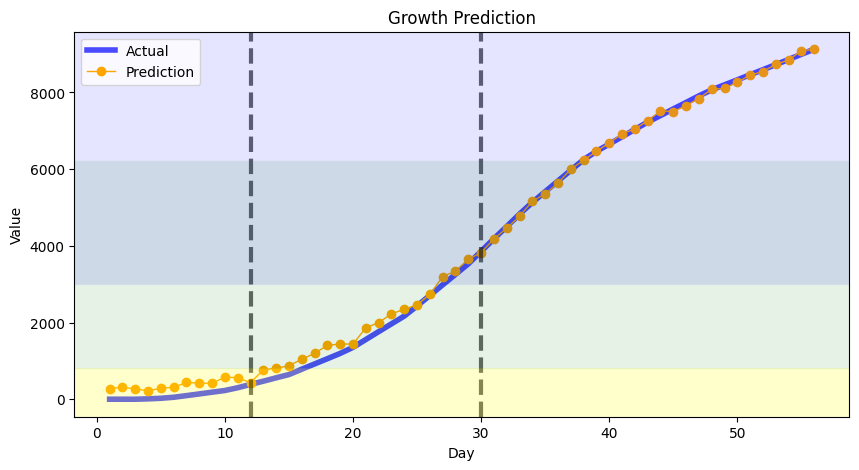

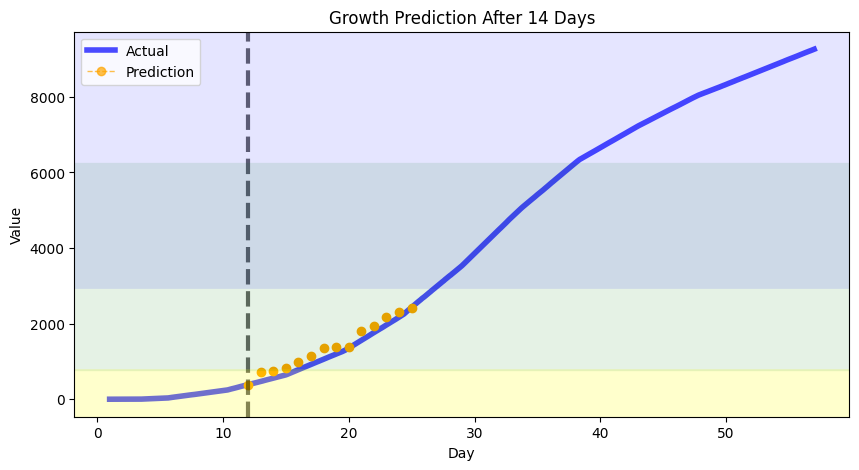

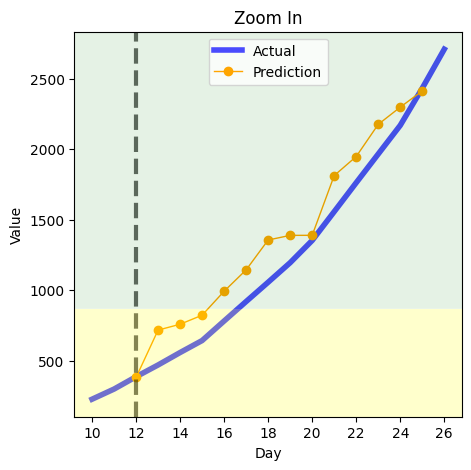

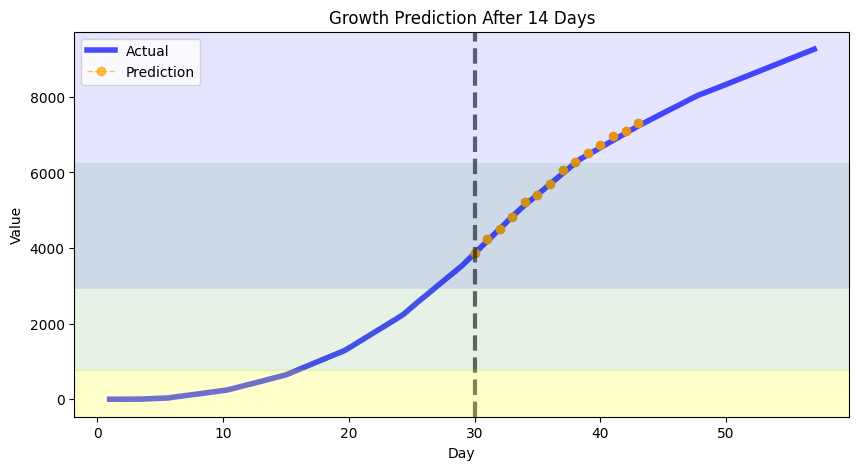

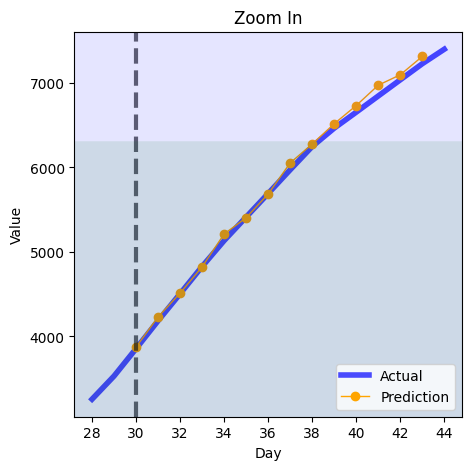

In [5]:
p_scaler = StandardScaler()
p_scaler.fit(X_train_A)
train_scaled = p_scaler.transform(X_train_A)
test_scaled = p_scaler.transform(X_test_A)

xg_reg_A = xgboost.XGBRegressor(objective ='reg:squarederror',
                                colsample_bytree = 0.7,
                                learning_rate = 0.1,
                                max_depth = 3,
                                alpha = 10,
                                n_estimators = 10000,
                                random_state=41)

# 모델 훈련
xg_reg_A.fit(train_scaled, y_train_A)

# fig, ax = plt.subplots(figsize=(400, 50))
# xgboost.plot_tree(xg_reg_A, num_trees=0, ax=ax)
# plt.show()

# 테스트 데이터 예측
y_pred_A = xg_reg_A.predict(test_scaled)

# 테스트 데이터 예측 결과 평가
mse = mean_squared_error(y_test_A, y_pred_A)
print(f'Mean Squared Error: {mse}')

# 데이터 추출
selected_indices_A = df_test.index[::144]
selected_indices_A_normalized = (selected_indices_A / 144) + 1
selected_actual_values_A = y_test_A[selected_indices_A]
selected_predicted_values_A = y_pred_A[selected_indices_A]

plt.figure(figsize=(10, 5))
plt.plot(selected_indices_A_normalized, selected_actual_values_A, color='blue', label='Actual', linewidth=4, alpha=0.7)
plt.plot(selected_indices_A_normalized, selected_predicted_values_A, color='orange', label='Prediction', linewidth=1, marker='o')
plt.axvline(x=12, color='black', linestyle='--', alpha=0.6, linewidth=3)
plt.axvline(x=30, color='black', linestyle='--', alpha=0.6, linewidth=3)
plt.axhline(y=180, color='yellow', linestyle='-', alpha=0.2, linewidth=35)
plt.axhline(y=3500, color='green', linestyle='-', alpha=0.1, linewidth=150)
plt.axhline(y=6600, color='blue', linestyle='-', alpha=0.1, linewidth=200)
plt.xlabel("Day")
plt.ylabel("Value")
plt.title("Growth Prediction")
plt.legend()
plt.show()

# 데이터 추출
selected_indices_BX = df_test.index[::144]
selected_indices_B = df_test.index[1584:3600:144]
selected_indices_BX_normalized = (selected_indices_BX / 144) + 1
selected_indices_B_normalized = (selected_indices_B / 144) + 1
selected_actual_values_B = y_test_A[selected_indices_B]
selected_predicted_values_B = y_pred_A[selected_indices_B] - 50

all_indices_normalized = (df_test.index / 144) + 1
plt.figure(figsize=(10, 5))
plt.plot(all_indices_normalized, y_test_A, color='blue', label='Actual', linewidth=4, alpha=0.7)

for i in range(len(selected_indices_BX_normalized)):
    if len(selected_predicted_values_B[i:i+1]) > 0:
        plt.plot(selected_indices_BX_normalized[i:i+1] + 11, selected_predicted_values_B[i:i+1], color='orange', linestyle='--', linewidth=1, marker='o')

plt.plot([], [], color='orange', linestyle='--', linewidth=1, alpha=0.7, marker='o', label='Prediction')
plt.axvline(x=12, color='black', linestyle='--', alpha=0.6, linewidth=3)
plt.axhline(y=170, color='yellow', linestyle='-', alpha=0.2, linewidth=35)
plt.axhline(y=3500, color='green', linestyle='-', alpha=0.1, linewidth=150)
plt.axhline(y=6600, color='blue', linestyle='-', alpha=0.1, linewidth=200)
plt.xlabel("Day")
plt.ylabel("Value")
plt.title("Growth Prediction After 14 Days")
plt.legend()
plt.show()

selected_indices_B2 = df_test.index[1584:3600:144]
selected_indices_B2_normalized = (selected_indices_B2 / 144) + 1
selected_predicted_values_B2 = y_pred_A[selected_indices_B2] - 50
selected_indices_B3 = df_test.index[1296:3744:144]
selected_indices_B3_normalized = (selected_indices_B3 / 144) + 1
selected_actual_values_B3 = y_test_A[selected_indices_B3]
errors_predicted = y_pred_A[selected_indices_B2] - 50
errors_actual = y_test_A[selected_indices_B2]
errors_B3 = np.abs(errors_actual - errors_predicted) / errors_actual * 100

plt.figure(figsize=(5, 5))
plt.plot(selected_indices_B3_normalized, selected_actual_values_B3, color='blue', label='Actual', linewidth=4, alpha=0.7)
plt.plot(selected_indices_B2_normalized, selected_predicted_values_B2, color='orange', label='Prediction', linewidth=1, marker='o')
# for i, error in enumerate(errors_B3):
#     if i % 2 == 1:
#         continue
#     plt.text(selected_indices_B2_normalized[i] + 0.1, selected_predicted_values_B2[i] - 20, f'------ {error:.2f}%', color='red', fontsize=8)
plt.axvline(x=12, color='black', linestyle='--', alpha=0.6, linewidth=3)
plt.axhline(y=400, color='yellow', linestyle='-', alpha=0.2, linewidth=95)
plt.axhline(y=2350, color='green', linestyle='-', alpha=0.1, linewidth=300)
plt.xlabel("Day")
plt.ylabel("Value")
plt.title("Zoom In")
plt.legend()
plt.show()

# 데이터 추출
selected_indices_CX = df_test.index[::144]
selected_indices_C = df_test.index[4176:6192:144]
selected_indices_CX_normalized = (selected_indices_CX / 144) + 1
selected_indices_C_normalized = (selected_indices_C / 144) + 1
selected_actual_values_C = y_test_A[selected_indices_C]
selected_predicted_values_C = y_pred_A[selected_indices_C] + 50

all_indices_normalized = (df_test.index / 144) + 1
plt.figure(figsize=(10, 5))
plt.plot(all_indices_normalized, y_test_A, color='blue', label='Actual', linewidth=4, alpha=0.7)

for i in range(len(selected_indices_CX_normalized)):
    if len(selected_predicted_values_C[i:i+1]) > 0:
        plt.plot(selected_indices_CX_normalized[i:i+1] + 29, selected_predicted_values_C[i:i+1], color='orange', linestyle='--', linewidth=1, marker='o')

plt.plot([], [], color='orange', linestyle='--', linewidth=1, alpha=0.7, marker='o', label='Prediction')
plt.axvline(x=30, color='black', linestyle='--', alpha=0.6, linewidth=3)
plt.axhline(y=170, color='yellow', linestyle='-', alpha=0.2, linewidth=35)
plt.axhline(y=3500, color='green', linestyle='-', alpha=0.1, linewidth=150)
plt.axhline(y=6600, color='blue', linestyle='-', alpha=0.1, linewidth=200)
plt.xlabel("Day")
plt.ylabel("Value")
plt.title("Growth Prediction After 14 Days")
plt.legend()
plt.show()

selected_indices_C2 = df_test.index[4176:6192:144]
selected_indices_C2_normalized = (selected_indices_C2 / 144) + 1
selected_predicted_values_C2 = y_pred_A[selected_indices_C2] + 50
selected_indices_C3 = df_test.index[3888:6336:144]
selected_indices_C3_normalized = (selected_indices_C3 / 144) + 1
selected_actual_values_C3 = y_test_A[selected_indices_C3]
errors_predicted = y_pred_A[selected_indices_C2] + 50
errors_actual = y_test_A[selected_indices_C2]
errors_C3 = np.abs(errors_actual - errors_predicted) / errors_actual * 100

plt.figure(figsize=(5, 5))
plt.plot(selected_indices_C3_normalized, selected_actual_values_C3, color='blue', label='Actual', linewidth=4, alpha=0.7)
plt.plot(selected_indices_C2_normalized, selected_predicted_values_C2, color='orange', label='Prediction', linewidth=1, marker='o')
# for i, error in enumerate(errors_C3):
#     plt.text(selected_indices_C2_normalized[i] + 0.1, selected_predicted_values_C2[i] - 20, f'------ {error:.2f}%', color='red', fontsize=8)
plt.axvline(x=30, color='black', linestyle='--', alpha=0.6, linewidth=3)
plt.axhline(y=4500, color='green', linestyle='-', alpha=0.1, linewidth=220)
plt.axhline(y=5200, color='blue', linestyle='-', alpha=0.1, linewidth=400)
plt.xlabel("Day")
plt.ylabel("Value")
plt.title("Zoom In")
plt.legend()
plt.show()